In [182]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from bert.tokenization import FullTokenizer
from tqdm import tqdm
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()


# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


# Data

First, we load the sample data IMDB data

false          744
partly true    655
true           157
Name: labelCode, dtype: int64
(1244, 7)
(312, 7)


,sentence,claimant,date,id,polarity,related_articles,labelCode
763,"In May 2017, the ACLU issued a warning for Ame...",,2017-05-10,2924,2,"[120774, 134939, 143189]",true
835,"Says Tammy Baldwin ""supported legislation allo...",Restoration PAC,2017-03-21,7162,1,"[9088, 26681, 11127]",partly true
1216,Eating farm-raised tilapia and other fish from...,,2018-04-12,16525,1,"[110492, 111520, 117739]",partly true
559,An MSNBC crew blocked a handicapped parking sp...,,2018-11-07,7830,1,"[104491, 149735]",partly true
684,The U.S. has a global trade deficit of $800 bi...,,2018-03-09,14266,0,"[144325, 144327, 33235, 151147, 151528]",false


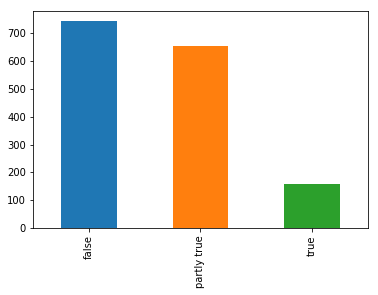

In [183]:
train_df = pd.read_json ('data/train.json')

train_df = train_df.sample(frac=.10).reset_index(drop=True)

labels = {0:'false', 1:'partly true', 2:'true'}

def label(x):
    return labels[x]

train_df['labelCode'] = train_df.label.apply(label)

print(train_df.labelCode.value_counts())
train_df.labelCode.value_counts().plot(kind='bar')

train_df.rename(columns={"claim": "sentence", "label": "polarity"}, inplace=True)

train_df.shape
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_df, test_size = 0.2, random_state = 0)
print(train_df.shape)
print(test_df.shape)
train_df.tail()

In [184]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

max_seq_length = 256

# encode class values as integers
encoder = LabelEncoder()


# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()
print(train_text[0], train_text.shape)
print(train_label[0])

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()
print(test_text.shape)


encoder.fit(train_label)
train_label = encoder.fit_transform(train_label)
train_label = np_utils.to_categorical(train_label)
print(train_label.shape, train_label[0])
test_label = encoder.fit_transform(test_label)
test_label = np_utils.to_categorical(test_label)
print(test_label.shape, test_label[0])


['A German football club was banned from playing games outside Germany in 1934, after they failed to give a Nazi salute.'] (1244, 1)
1
(312, 1)
(1244, 3) [0. 1. 0.]
(312, 3) [1. 0. 0.]


# Tokenize

Next, tokenize our text to create `input_ids`, `input_masks`, and `segment_ids`

In [185]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids   = [0] * max_seq_length
        input_mask  = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label       = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
#         np.array(labels).reshape(-1, 1),
        np.array(labels),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples



In [186]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)

print('train_input_ids', train_input_ids.shape)
print('train_input_masks', train_input_masks.shape)
print('train_segment_ids', train_segment_ids.shape)
print('train_labels', train_labels.shape)

(test_input_ids, test_input_masks, test_segment_ids, test_labels) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)
    
print('test_input_ids', test_input_ids.shape)
print('test_input_masks', test_input_masks.shape)
print('test_segment_ids', test_segment_ids.shape)
print('test_labels', test_labels.shape)

Converting examples to features: 100%|██████████| 312/312 [00:00<00:00, 2725.08it/s]

train_input_ids (1244, 256)
train_input_masks (1244, 256)
train_segment_ids (1244, 256)
train_labels (1244, 3)
test_input_ids (312, 256)
test_input_masks (312, 256)
test_segment_ids (312, 256)
test_labels (312, 3)


In [ ]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.
    Args:
    features: numpy array of features used for training or inference
    labels: numpy array of labels for each example
    shuffle: boolean for whether to shuffle the data or not (set True for
      training, False for evaluation)
    num_epochs: number of epochs to provide the data for
    batch_size: batch size for training
    Returns:
    A tf.data.Dataset that can provide data to the Keras model for training or
      evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset



In [6]:
print('train_input_ids', train_input_ids[1])
print('train_input_masks', train_input_masks[1])
print('train_segment_ids', train_segment_ids[1])
print('train_labels', train_labels[1])

train_input_ids [  101 26914  2378 11300  2522  1011  6485  1037  2857  2740  2729  3021
  2008  2018  2019  3265 11405  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     

In [7]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError("Undefined pooling type (must be either first or mean, but is %s" % self.pooling)

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path, trainable=self.trainable, name="%s_module" % self.name)

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError("Undefined pooling type (must be either first or mean, but is %s" % self.pooling)

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append("encoder/layer_{str(11 - %s)}" % i)

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError("Undefined pooling type (must be either first or mean, but is %s" % self.pooling)

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [8]:
# Build model
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    
#     encoder
    
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(3, activation='softmax')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)


In [9]:
model = build_model(max_seq_length)

# Instantiate variables
initialize_vars(sess)

model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], train_labels,
#     validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=1, verbose=1,
    batch_size=32
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [10]:
%%time

model.save('BertModel.h5')

pre_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions before we clear and reload model

# Clear and load model
model = None
model = build_model(max_seq_length)
initialize_vars(sess)
model.load_weights('BertModel.h5')

# post_save_preds = model.predict([test_input_ids[0:100], 
#                                 test_input_masks[0:100], 
#                                 test_segment_ids[0:100]]
#                               ) # predictions after we clear and reload model
# all(pre_save_preds == post_save_preds) # Are they the same?

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate([test_input_ids, 
                                test_input_masks, 
                                test_segment_ids], test_labels,
                               verbose=2)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % loss)

print(post_save_preds)


In [11]:
%%time

from sklearn.metrics import f1_score, classification_report

y_preds = model.predict([test_input_ids, 
                                test_input_masks, 
                                test_segment_ids])



CPU times: user 15min 28s, sys: 16.2 s, total: 15min 44s
Wall time: 2min 2s


In [12]:
print(y_preds[0], y_preds.shape)
y_preds = np.argmax(y_preds, axis=1)
print(y_preds, y_preds.shape)
print(test_labels[0], test_labels.shape)
# Results
y_true = np.argmax(test_labels, axis=1)
y_preds = y_preds.reshape((y_preds.shape[0], 1))
y_true = y_true.reshape((y_true.shape[0], 1))
print(y_true)
# print(y_true.reshape((y_true.shape[0], 1)).shape)
print('sklearn Macro-F1-Score:', f1_score(y_true, y_preds, average='macro'))
print('sklearn Micro-F1-Score:', f1_score(y_true, y_preds, average='micro'))  
print('sklearn weighted-F1-Score:', f1_score(y_true, y_preds, average='weighted'))  
print('sklearn no average-F1-Score:', f1_score(y_true, y_preds, average=None))

print(classification_report(y_true, y_preds))

[0.3660267  0.5337784  0.10019479] (312, 3)
[1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0
 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1
 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1
 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0
 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0
 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0
 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1] (312,)
[0. 0. 1.] (312, 3)
[[2]
 [0]
 [0]
 [0]
 [1]
 [0]
 [2]
 [0]
 [2]
 [0]
 [1]
 [2]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [1]
 [2]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
# Export the model to a local SavedModel directory 
export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
print("Model exported to: ", export_path)


Model exported to:  b'keras_export/1573943894'


In [47]:
# GCloud
! export GOOGLE_APPLICATION_CREDENTIALS="/home/sonic/leadersprize/fakenews-40cea3fac9e2.json"
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/sonic/leadersprize/fakenews-40cea3fac9e2.json'
# %env GOOGLE_APPLICATION_CREDENTIALS '/home/sonic/leadersprize/fakenews-40cea3fac9e2.json'

PROJECT_ID = "fakenews-259222" #@param {type:"string"}
BUCKET_NAME =  PROJECT_ID + "-model" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"

JOB_NAME = 'my_first_keras_job'
JOB_DIR = 'gs://' + BUCKET_NAME + '/keras-job-dir'

! gcloud config set project $PROJECT_ID
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

Updated property [core/project].
Updated property [ml_engine/local_python].


In [48]:
! pwd
! echo %GOOGLE_APPLICATION_CREDENTIALS%

/home/sonic/leadersprize
%GOOGLE_APPLICATION_CREDENTIALS%


In [51]:
# Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.
! gsutil mb -l $REGION gs://$BUCKET_NAME
# ! gsutil acl set -R project-private gs://$BUCKET_NAME
! gsutil ls -al gs://$BUCKET_NAME

Creating gs://fakenews-259222-model/...
ServiceException: 409 Bucket fakenews-259222-model already exists.
                                 gs://fakenews-259222-model/keras-job-dir/


In [52]:
# Export the model to a SavedModel directory in Cloud Storage

export_path = tf.contrib.saved_model.save_keras_model(model, JOB_DIR + '/keras_export')
print("Model exported to: ", export_path)

Model exported to:  b'gs://fakenews-259222-model/keras-job-dir/keras_export/1573947349'


In [53]:
MODEL_NAME = "my_first_keras_model"

! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION


Created ml engine model [projects/fakenews-259222/models/my_first_keras_model].


In [162]:
! gsutil 

CommandException: option -l not recognized


In [159]:
# Update datasets
! gsutil -m cp -r data/train.json gs://$BUCKET_NAME/data

Copying file://data/train.json [Content-Type=application/json]...
- [1/1 files][  4.4 MiB/  4.4 MiB] 100% Done                                    
Operation completed over 1 objects/4.4 MiB.                                      


In [181]:
# Storage directory
import tempfile
DATA_DIR = os.path.join(tempfile.gettempdir(), 'fakenews_data')

# Download options.
# https://storage.cloud.google.com/[BUCKET_NAME]/[OBJECT_NAME]
DATA_URL = ('gs://%s/data' % BUCKET_NAME)
TRAINING_FILE = 'train.json'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)

print(TRAINING_URL)

if (tf.io.gfile.exists(TRAINING_URL)):
    print(TRAINING_URL)
    
tf.io.gfile.copy(
    TRAINING_URL,
    'datadd/',
    overwrite=True
)

with tf.io.gfile.GFile(TRAINING_URL, "rb") as file:
#     options_dict = (file.read().decode("utf-8"))
    train_df = pd.read_json (file.read())

train_df.head()

gs://fakenews-259222-model/data/train.json
gs://fakenews-259222-model/data/train.json


,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [168]:
MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/

# Pick the directory with the latest tiAmestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

ERROR: (gcloud.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [171]:
# test_input_ids[:1]
import json

! rm prediction_input.json

prediction_json = { "instances": [test_input_ids[:1].tolist(),
                                            test_input_masks[:1].tolist(), 
                                            test_segment_ids[:1].tolist()] }
# prediction_json = []
# prediction_df = pd.DataFrame(prediction_json)
# prediction_df.to_json('prediction_input.json')

# with open('prediction_input.json', 'w') as json_file:
#     for row in prediction_df.values.tolist():
#         json.dump(row, json_file)
#         json_file.write('\n')

# with open("prediction_input.json", "w") as write_file:
#     json.dump(prediction_json, write_file)


predict_instance_json = "prediction_input.json"
predict_instance_tfr = "inputs.tfr"

with open(predict_instance_json, "wb") as fp:
        fp.write(json.dumps(prediction_json).encode())
    
    
! cat prediction_input.json

{"instances": [[[101, 2019, 5334, 6458, 7219, 5895, 1005, 7579, 21046, 3070, 2055, 1996, 3684, 2011, 7302, 2041, 2008, 3548, 3529, 1999, 5712, 11997, 2007, 2714, 3785, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [170]:
{"instances": prediction_json}
! gcloud ai-platform models list

NAME                  DEFAULT_VERSION_NAME
my_first_keras_model  v1


In [101]:
y_preds = model.predict(prediction_json)
y_preds

array([[0.36602676, 0.5337784 , 0.1001948 ],
       [0.5724356 , 0.38378447, 0.04377986],
       [0.42317846, 0.5072334 , 0.06958818],
       [0.1621002 , 0.77673244, 0.06116732],
       [0.30797893, 0.60937566, 0.08264544],
       [0.30571237, 0.6302835 , 0.06400414],
       [0.17362562, 0.76148766, 0.06488673],
       [0.2787502 , 0.61786336, 0.10338645],
       [0.6784693 , 0.26468378, 0.05684688],
       [0.46706417, 0.4457351 , 0.08720069]], dtype=float32)

In [151]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

{
  "error": "Prediction failed: Unexpected tensor name: instances;;;;;;;;"
}


In [ ]:
# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output

# Clean up 

In [ ]:

# Delete model version resource
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL_NAME 

# Delete model resource
! gcloud ai-platform models delete $MODEL_NAME --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $JOB_DIR

# If the training job is still running, cancel it
! gcloud ai-platform jobs cancel $JOB_NAME --quiet --verbosity critical